In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import humanfriendly as HF
import os 
import sys
import string
import re
np.random.seed(0)
import logging
format = "%(asctime)s: %(message)s"
handlers = [logging.StreamHandler(sys.stdout)]
logging.basicConfig(format=format, level=logging.INFO,datefmt="%H:%M:%S",stream=sys.stdout)
OUTPUT_PATH = os.environ.get("OUTPUT_PATH","/source/mx-test")
MAX_WORKERS = int(os.environ.get("MAX_WORKERS",5))


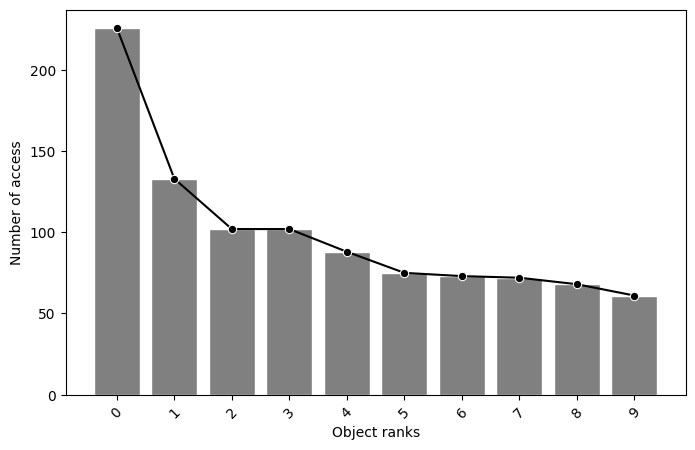

In [ ]:
# p.random.seed(0)

def generate_interarrival_times(n, avg_interarrival, distribution="exponential",**kwargs):
    """Generate interarrival times based on a specified distribution."""
    if distribution == "exponential":
        return np.random.exponential(scale=avg_interarrival, size=n)
    elif distribution == "uniform":
        return np.random.uniform(low=0, high=2 * avg_interarrival, size=n)
    elif distribution == "geometric":
        return np.random.geometric(p=1.0 / avg_interarrival, size=n)
    elif distribution == "poisson":
        return np.random.poisson(lam=avg_interarrival, size=n)
    else:
        raise ValueError("Unsupported interarrival time distribution")

def generate_object_rankings(n, num_objects, distribution="zipf",**kwargs):
    """Generate object rankings based on a specified probability distribution."""
    if distribution == "zipf":
        return np.random.zipf(a=kwargs.get("alpha",1.2), size=n) % num_objects
    elif distribution == "uniform":
        # return np.random.zipf(a=0,size=n) % num_objects
        return np.random.randint(low=0, high=num_objects, size=n)
    elif distribution == "geometric":
        return np.random.geometric(p=kwargs.get("p",0.5), size=n) % num_objects
    elif distribution == "exponential":
        return np.random.exponential(scale=kwargs.get("scale",1.0), size=n).astype(int) % num_objects
    else:
        raise ValueError("Unsupported ranking distribution")

def generate_producer_trace(n, avg_interarrival, num_buckets, num_keys, size_range=(100, 10000), interarrival_dist="exponential", save=False):
    """Generate a producer trace (writes) with bucket IDs and keys as strings."""
    interarrival_times = generate_interarrival_times(n, avg_interarrival, interarrival_dist)
    timestamps = np.cumsum(interarrival_times)
    
    # Generate unique bucket IDs and keys for producer trace
    bucket_ids = [f"bucket-{i%num_buckets}" for i in range(n)]
    keys = [f"key-{random.randint(0, num_keys-1)}" for _ in range(n)]
    sizes = np.random.randint(size_range[0], size_range[1], size=n)
    
    df = pd.DataFrame({
        "timestamp": timestamps,
        "interarrival_time": interarrival_times,
        "bucket_id": bucket_ids,
        "key": keys,
        "size": sizes
    })
    
    if save:
        df.to_csv("producer_trace.csv", index=False)
    
    return df

def generate_consumer_trace(n, avg_interarrival, num_buckets, num_keys, ranking_dist="zipf", interarrival_dist="exponential", save=False,**kwargs):
    """Generate a consumer trace (reads) ensuring each unique object is accessed at least once.
    
    Each unique object is defined as a combination of bucket and key.
    The trace will include guaranteed accesses for all unique objects, and the remaining accesses
    are generated based on the selected probability distribution.
    """
    total_unique = num_buckets * num_keys
    
    # Generate guaranteed keys: all unique combinations.
    guaranteed_keys = [f"bucket-{b}_key-{k}" for b in range(num_buckets) for k in range(num_keys)]
    
    # If n is less than total_unique, choose n unique objects randomly.
    if n < total_unique:
        guaranteed_keys = random.sample(guaranteed_keys, n)
        remainder = 0
    else:
        remainder = n - total_unique
    
    additional_keys = []
    if remainder > 0:
        # Generate additional keys based on the ranking distribution over total_unique objects.
        additional_indices = generate_object_rankings(remainder, total_unique, distribution=ranking_dist,**kwargs)
        additional_keys = [guaranteed_keys[i] for i in additional_indices]
    
    # Combine the guaranteed keys with the additional keys
    all_keys = guaranteed_keys + additional_keys
    # Shuffle the order to simulate random accesses
    random.shuffle(all_keys)
    
    # Generate interarrival times and timestamps
    interarrival_times = generate_interarrival_times(n, avg_interarrival, interarrival_dist)
    timestamps = np.cumsum(interarrival_times)
    
    # For simplicity, randomly assign bucket_id from the object key (if desired, extract bucket from the key)
    bucket_ids = [key.split('_')[0] for key in all_keys]
    
    df = pd.DataFrame({
        "timestamp": timestamps,
        "interarrival_time": interarrival_times,
        "bucket_id": bucket_ids,
        "key": all_keys
    })
    
    if save:
        df.to_csv("consumer_trace.csv", index=False)
    
    return df


def plot_object_ranking_distribution(consumer_trace, num_keys=10):
    """Plot the object ranking distribution to verify trace generation."""
    plt.figure(figsize=(8, 5))
    
    # Count frequency of accesses per object (key)
    object_counts = consumer_trace["key"].value_counts().sort_values(ascending=False)
    
    # Limit to the top `num_keys` most accessed objects
    top_keys = object_counts.head(num_keys)
    x=range(0,num_keys)
    sns.barplot(x=x, y=top_keys.values, color="grey", edgecolor="white")
    sns.lineplot(x=x, y=top_keys.values, color="black",marker="o")
    
    plt.xlabel("Object ranks")
    plt.ylabel("Number of access")
    # plt.title(f"Object Access Distribution (from Trace)")
    plt.xticks(rotation=45)
    plt.show()
# Example Usage:
n_requests = 1000
avg_interarrival = 1.0  # Seconds
num_buckets = 1  # For simplicity, one bucket (can be more)
num_keys = 10  # Number of unique keys

TRACE_PATH = os.environ.get("TRACE_PATH",f"/traces/trace-{n_requests}_{num_keys}.csv")
# Generate the producer trace
# producer_trace = generate_producer_trace(n_requests, avg_interarrival, num_buckets, num_keys)

# Generate the consumer trace for different ranking distributions:
consumer_trace_zipf = generate_consumer_trace(n_requests, avg_interarrival, num_buckets, num_keys, ranking_dist="zipf",save=save)
consumer_trace_uniform = generate_consumer_trace(n_requests, avg_interarrival, num_buckets, num_keys, ranking_dist="uniform",save=save)
consumer_trace_geometric = generate_consumer_trace(n_requests, avg_interarrival, num_buckets, num_keys, ranking_dist="geometric",save=save)
consumer_trace_exponential = generate_consumer_trace(n_requests, avg_interarrival, num_buckets, num_keys, ranking_dist="exponential",save=save)

# Plot the object access distribution for the Zipf-based consumer trace
plot_object_ranking_distribution(consumer_trace_zipf)
# plot_object_ranking_distribution(consumer_trace_uniform)
# plot_object_ranking_distribution(consumer_trace_geometric)
# plot_object_ranking_distribution(consumer_trace_exponential)
# consumer_trace_zipf
# print("Producer and Consumer traces have been generated and saved.")


In [ ]:
# consumer_trace_zipf
np.random.seed(0)
def process_consumer_trace(consumer_df):
    """
    Process a consumer trace:
      - For each unique combination of bucket_id and key, mark the first occurrence as 'PUT'
        and subsequent occurrences as 'GET'.
      - Modify the key column by removing the '{bucket_id}_' prefix.
    
    Parameters:
      consumer_df: DataFrame with columns [timestamp, interarrival_time, bucket_id, key]
      
    Returns:
      processed_df: DataFrame with an additional 'operation' column and updated 'key'.
    """
    # Sort the DataFrame by timestamp to ensure proper chronological order
    consumer_df = consumer_df.sort_values(by="timestamp").reset_index(drop=True)
    
    # Initialize a dictionary to keep track of seen (bucket_id, key) combinations
    seen = {}
    operations = []
    new_keys = []
    sizes  = []
    
    avg_object_size = HF.parse_size("1MB")
    std_object_size = HF.parse_size("1MB")
    for _, row in consumer_df.iterrows():
        bucket = row["bucket_id"]
        key = row["key"]
        # Remove the bucket prefix from the key if it follows the pattern "{bucket_id}_{string}"
        prefix = f"{bucket}_"
        if key.startswith(prefix):
            key_modified = key[len(prefix):]
        else:
            key_modified = key
        
        # Use (bucket, key_modified) as the unique combination
        combination = (bucket, key_modified)
        if combination not in seen:
            seen[combination] = True
            operations.append("PUT")
        else:
            operations.append("GET")
        
        new_keys.append(key_modified)
        sizes.append(0)
    
    # Add new columns to the DataFrame
    consumer_df["operation"] = operations
    consumer_df["key"] = new_keys  # Update the key column without bucket prefix
    consumer_df["size"] = np.random.normal(loc=avg_object_size, scale=std_object_size)
    
    # Reorder columns if desired
    processed_df = consumer_df[["timestamp", "interarrival_time", "operation", "bucket_id", "key","size"]]
    return processed_df

process_consumer_trace(consumer_df=consumer_trace_zipf)
# .to_csv(TRACE_PATH)

In [ ]:
def create_file(filename, size):
    p = [0]*46 + [.5] +([.1]*5)
    with open(f"{OUTPUT_PATH}/{filename}",'w') as f:
        letters        = np.array(list(string.ascii_letters))
        random_letters = np.random.choice(letters,size=size,p=p).tolist()
        text           = ''.join(random_letters)
        text = re.sub("(.{100})", "\\1\r\n", text, 0, re.DOTALL)
        f.write(text)
    logging.info('Random file with size %f generated ok'%size)
    return 

